## Vmax tracking using IBTrACS

TODO: 

- Asymmetry information?

- IBTrACS or EBTRK? ==> JTWC Best-Tracks

- Latent parameter?

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'input_size':  len(input_variables),
          'output_size': len(target_variable),
          'seq_len':     360,  
          
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,     # dropout probability
    
          'batch_size':  1,     
          'n_epochs':    50,     # nb of epochs
          'learn_rate':  0.001,  # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/rmax_seq_pred_ibtracs/lstmv02.pth',
    'save_path':    '/home/arthur/results/TCsLifeMonitFromObs/kalman/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
### FILTERS
# Convert to m/s and km units
ds_ibt['usa_wind']    *= 0.5144
ds_ibt['storm_speed'] *= 0.5144
ds_ibt['usa_r34']     *= 1.852
ds_ibt['usa_rmw']     *= 1.852

### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (1): ", len(ds_ibt['storm']))

### 2) FINAL DATASET
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (2): ", len(ds_ibt['storm'])) 
                
### 3) FLIP TCs of Southern hemisphere
### Take the symmetric with respect to Equator
### So storm_dir = PI - storm_dir
ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# Then project to (u, v) ref.
ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1054.60it/s]


Total samples after (1):  143


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 777.35it/s]


Total samples after (2):  110


In [6]:
### COMPUTE RMAX_CK22
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    f     = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at lat° latitude and assuming it's constant 
    return f

def get_rmax_ck22(Vmax, R17, fcor, intercept, coef1, coef2):
    M17     = R17 * 1000 * 17.5 + 0.5 * fcor * ((R17 * 1000) ** 2) 
    M_ratio = intercept * np.exp(coef1 * (Vmax - 17.5) + coef2 * (Vmax - 17.5) * 0.5 * fcor * R17 * 1000)
    Mmax    = M_ratio * M17
    Rmax    = (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)
    return Rmax

ds_ibt['rmax_ck22'] = get_rmax_ck22(
    Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=coriolis(np.abs(ds_ibt['usa_lat'])), 
    intercept=0.459, coef1=0.00534, coef2=-0.00337
) / 1000

In [7]:
### CREATE FULL DATASET

final_params = ['usa_wind', 'usa_rmw', 'usa_r34', 'fcor']
# final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']

def create_Xt_1_and_Xt(ds_ibt, final_params=['usa_wind', 'usa_rmw', 'usa_r34', 'fcor', 'u_trans', 'v_trans'], fcor_boost=1):
    '''So far, fcor is boosted by 1e6'''
    Xt_1 = [] # shape (n_samples, n_features)
    Xt   = [] # shape (n_samples, n_targets)
    
    # For each storm, build Xt_1 and Xt dataset.
    for s in tqdm(range(len(ds_ibt.storm))):
        # Select storm
        ds = ds_ibt.isel(storm=s)
        # Add derivatives
        for p in ['usa_rmw', 'usa_r34', 'usa_wind']:
            ds['{}_diff'.format(p)]     = ds[p] * np.nan
            ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
        # Add Coriolis
        ds['fcor'] = coriolis(np.abs(ds['usa_lat'])) * fcor_boost
        # Get only valid stime steps
        ds         = ds.dropna(dim='date_time', subset=params_of_interest + ['usa_rmw_diff', 'usa_r34_diff', 'usa_wind_diff'])

        # Add to X and Y dataset
        # final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']
        da           = ds[final_params].to_array().transpose()
        # print(da)
        for t in range(len(da['date_time']) - 1):
            Xt_1.append(da[t, :].values)
            Xt.append(da[t + 1, :].values)
        # print(Xt)
    
    # Convert to arrays
    Xt_1 = np.array(Xt_1)
    Xt   = np.array(Xt)
    
    return Xt, Xt_1
    
# Create dataset
fcor_boost=1e5
Xt_full, Xt_1_full = create_Xt_1_and_Xt(ds_ibt, final_params=['usa_wind', 'usa_rmw', 'usa_r34', 'fcor', 'u_trans', 'v_trans'], fcor_boost=fcor_boost)

100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 40.15it/s]


In [12]:
### CREATE SCENARIO DATASETS

### 0) REF. SCENARIO ==> X = [Vmax, Rmax, R34, fcor]
Xt   = Xt_full[:, :4]
Xt_1 = Xt_1_full[:, :4]
reg_mlr_0 = LinearRegression(fit_intercept=False)
reg_mlr_0.fit(Xt_1, Xt)
M_0 = reg_mlr_0.coef_
# print('M = \n' + str(np.around(M, 2)))
Q_0 = np.cov((Xt - reg_mlr_0.predict(Xt_1)).T)
# print('Q = \n' + str(np.around(Q, 2)))
H_0 = np.eye(M_0.shape[0])
R_0 = 0.1 * np.diag(np.nanstd(Xt_1, axis=0))

### 1) TC MOTION SCENARIO ==> X = [Vmax, Rmax, R34, fcor, u, v]
Xt   = Xt_full
Xt_1 = Xt_1_full
reg_mlr_1 = LinearRegression(fit_intercept=False)
reg_mlr_1.fit(Xt_1, Xt)
M_1 = reg_mlr_1.coef_
# print('M = \n' + str(np.around(M, 2)))
Q_1 = np.cov((Xt - reg_mlr_1.predict(Xt_1)).T)
# print('Q = \n' + str(np.around(Q, 2)))
H_1 = np.eye(M_1.shape[0])
R_1 = 0.1 * np.diag(np.nanstd(Xt_1, axis=0))

### 2) RMAX_CK22 SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v]
Xt_full, Xt_1_full = create_Xt_1_and_Xt(ds_ibt, final_params=['usa_wind', 'rmax_ck22', 'usa_r34', 'fcor', 'u_trans', 'v_trans'], fcor_boost=fcor_boost)
Xt   = Xt_full
Xt_1 = Xt_1_full
reg_mlr_2 = LinearRegression(fit_intercept=False)
reg_mlr_2.fit(Xt_1, Xt)
M_2 = reg_mlr_1.coef_
# print('M = \n' + str(np.around(M, 2)))
Q_2 = np.cov((Xt - reg_mlr_2.predict(Xt_1)).T)
# print('Q = \n' + str(np.around(Q, 2)))
H_2 = np.eye(M_2.shape[0])
R_2 = 0.1 * np.diag(np.nanstd(Xt_1, axis=0))

100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 40.62it/s]


In [9]:
### PERFORMANCE METRICS
def get_loglikelihood_vmax(param, x_a, P_a, Y):
    """Given a Kalman Filter param and registered analyzed states x_a and P_a, and observations, 
    computes the innovation log-likelihood at each time step, but only on the Vmax component. 
    Returns np.nan when observation are masked.    
    """
    x_f          = []
    P_f          = []
    Log_lik_vmax = []

    x_f.append(param.initial_state_mean)
    P_f.append(param.initial_state_covariance)
    for t in range(Y.shape[0] - 1):
        x_f.append(np.dot(param.transition_matrices, x_a[t]))
        P_f.append(np.dot(np.dot(param.transition_matrices, P_a[t]), param.transition_matrices.T) + param.transition_covariance)
        A   = copy.deepcopy((Y[t, :] - np.dot(param.observation_matrices, x_f[t])))
        SIG = np.dot(np.dot(param.observation_matrices, P_f[t]), param.observation_matrices.T) + param.observation_covariance
        B   = copy.deepcopy(np.linalg.inv(SIG))
        # Mask all values that don't relate to Vmax
        A[1:] = 0
        try: 
            Log_lik_vmax.append(0.5 * A.T@(B@A) - 0.5 * (np.log(2 * np.pi) + SIG[0, 0]))
        except ValueError: # When the value is masked, we add 0
            Log_lik_vmax.append(np.nan)
        
    return Log_lik_vmax, np.array(x_f)

def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))

### EM FUNCTION

def em_optimization(state_space_model, Y, n_iter=10):
    loglikelihoods    = np.zeros(n_iter)
    for i in range(len(loglikelihoods)):
        '''Bug solved by changing standard.py
        Details at https://stackoverflow.com/questions/37730850/when-using-pykalman-python-kalman-filter-what-data-type-does-loglikelihood-fu'''
        loglikelihoods[i] = state_space_model.loglikelihood(Y)
        state_space_model.em(Y, n_iter=1)
    return state_space_model, loglikelihoods

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


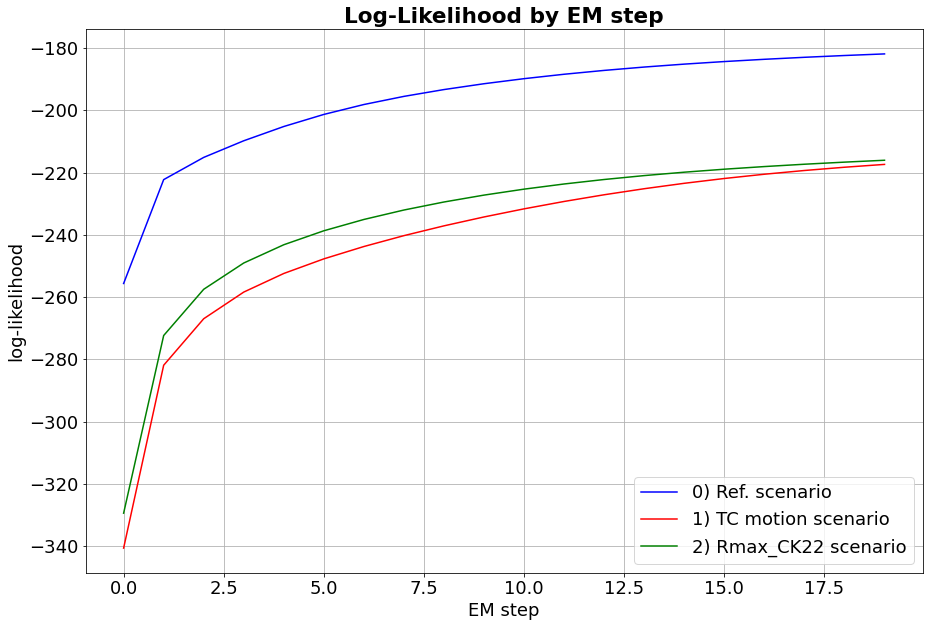


METRICS
0) Ref. scenario (blue)
Vmax Log-likelihood = -62.80
Vmax RMSE(x_s, Y)   = 0.23
Vmax RMSE(x_a, Y)   = 0.22

1) TC motion scenario (red)
Vmax Log-likelihood = -55.92
Vmax RMSE(x_s, Y)   = 0.11
Vmax RMSE(x_a, Y)   = 0.10

2) Rmax_CK22 scenario (green)
Vmax Log-likelihood = -51.85
Vmax RMSE(x_s, Y)   = 0.09
Vmax RMSE(x_a, Y)   = 0.09


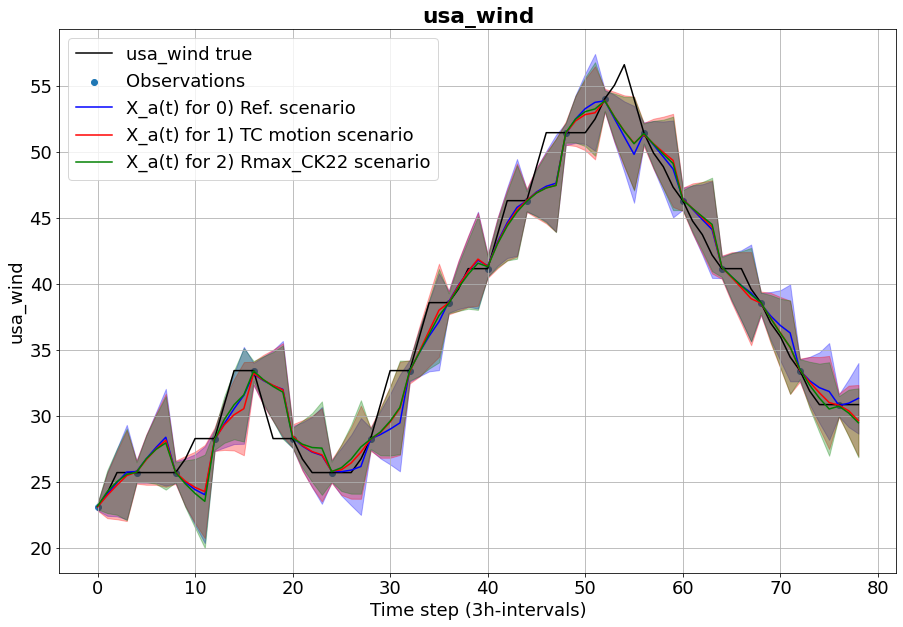

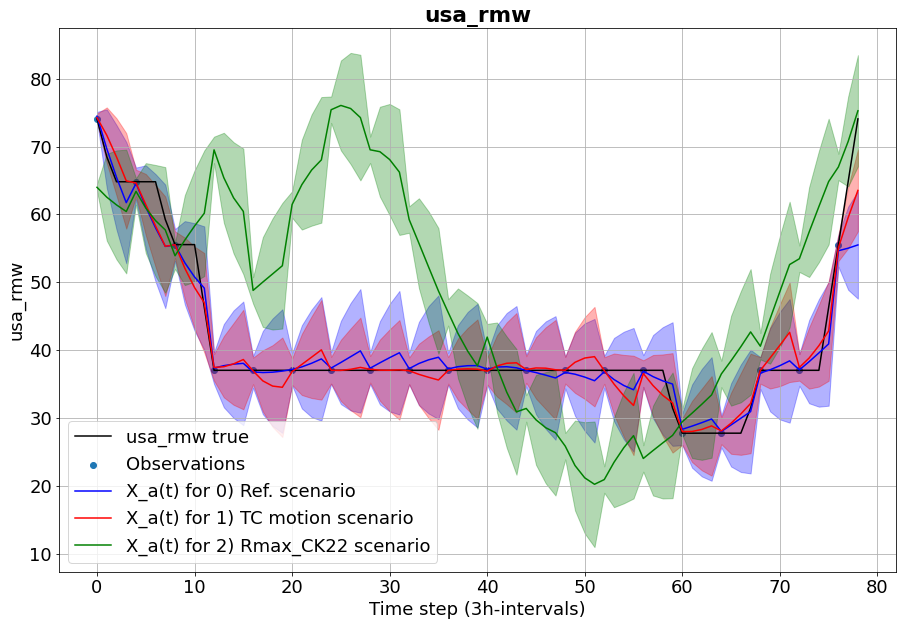

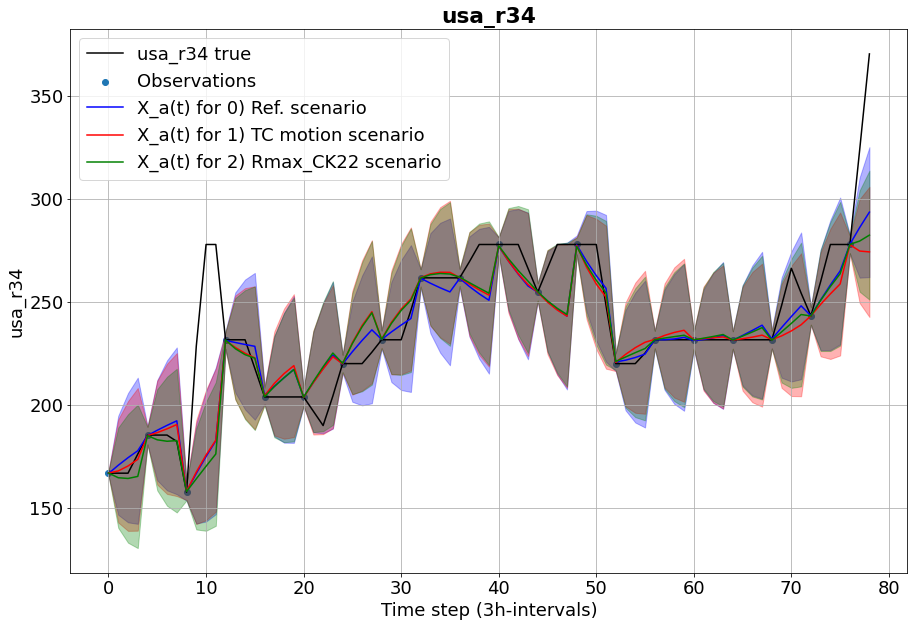

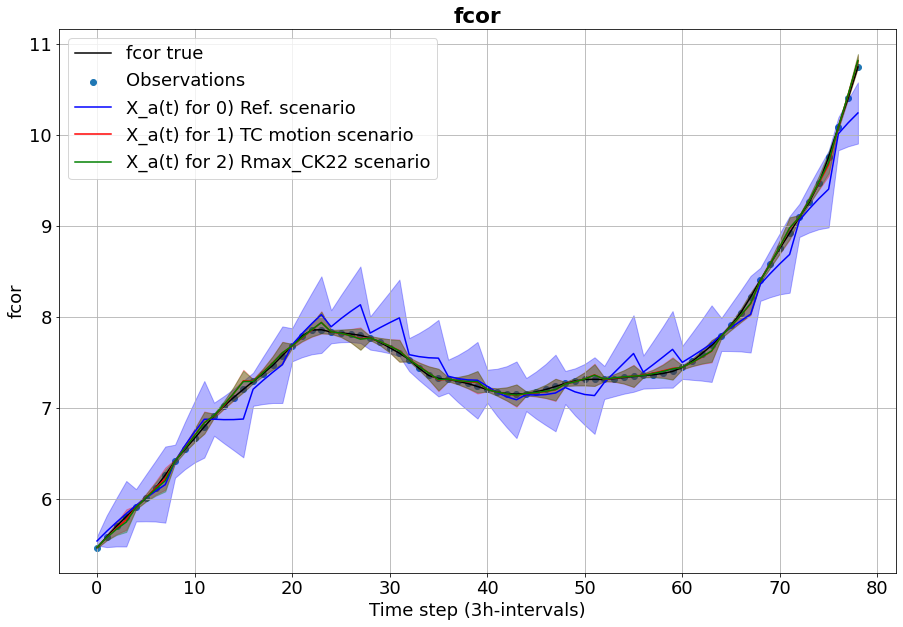

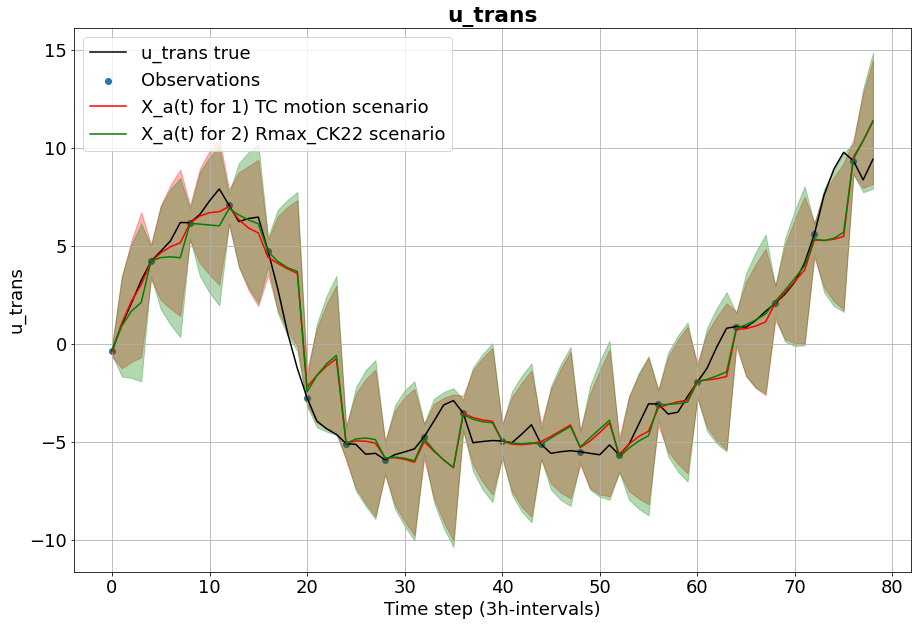

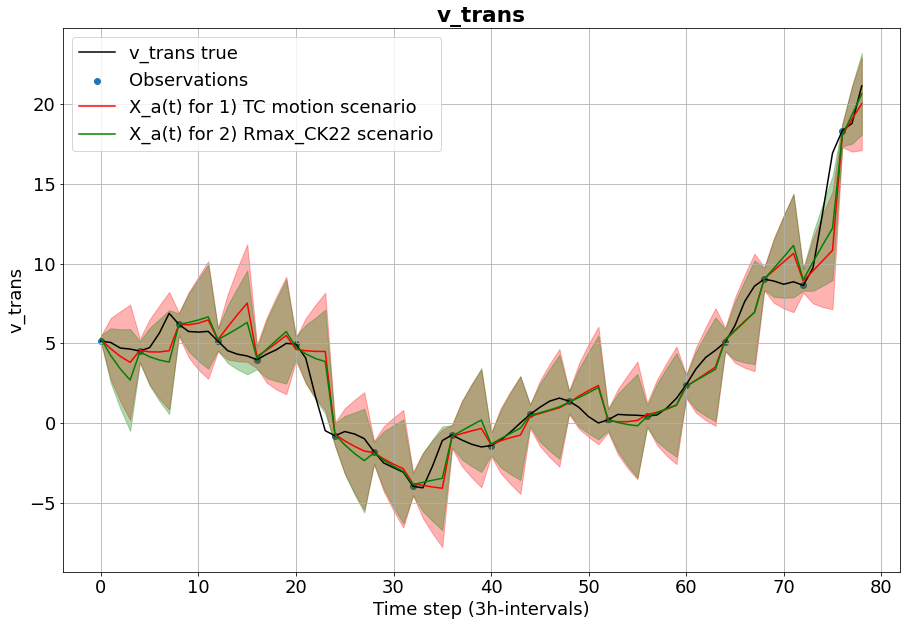

In [28]:
import copy
### CREATE NOISY OBSERVATIONS
k         = 5 # 5, 6, 7
ds0       = ds_ibt.isel(storm=slice(k, k + 1))
X_full, _ = create_Xt_1_and_Xt(ds0, final_params=['usa_wind', 'usa_rmw', 'usa_r34', 'fcor', 'u_trans', 'v_trans'], fcor_boost=fcor_boost)
obs_step  = 4
em_vars   = ['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'transition_covariance', 'observation_covariance']

### 0) REF. SCENARIO ==> X = [Vmax, Rmax, R34, fcor]
# Create sparse observations
X_0                   = copy.deepcopy(X_full[:, :4])
Y_0                   = copy.deepcopy(X_0)
mask_0                = np.ones(X_0.shape) # Mask where 1, keep where 0
mask_0[:, 3]          = 0 # Always keep fcor
mask_0[::obs_step, :] = 0 # Keep every 4th observation
Y_0                   = np.ma.masked_array(Y_0, mask=mask_0) # Mask every value where mask = 1
# Kalman filter
x_ini_0               = X_0[0, :]
P_ini_0               = copy.deepcopy(R_0)
state_space_model_0   = KalmanFilter(
    initial_state_mean=x_ini_0, initial_state_covariance=P_ini_0, 
    transition_matrices=M_0, transition_covariance=Q_0, 
    observation_matrices=H_0, observation_covariance=R_0,
    em_vars=em_vars
)
# Apply EM algorithm to tune x(0), P(0), M, Q and R
param_0, loglikelihoods_0 = em_optimization(state_space_model_0, Y_0, n_iter=20)
# Apply Kalman filter and smoother with the optimized parameters
x_a_0, P_a_0 = param_0.filter(Y_0)
x_s_0, P_s_0 = param_0.smooth(Y_0)

### 1) TC MOTION SCENARIO ==> X = [Vmax, Rmax, R34, fcor, u, v]
# Create sparse observations
X_1                   = copy.deepcopy(X_full)
Y_1                   = copy.deepcopy(X_1)
mask_1                = np.ones(X_1.shape) # Mask where 1, keep where 0
mask_1[:, 3]         = 0 # Always keep fcor
mask_1[::obs_step, :] = 0 # Keep every 4th observation
Y_1                   = np.ma.masked_array(Y_1, mask=mask_1) # Mask every value where mask = 1
# Kalman filter
x_ini_1               = X_1[0, :]
P_ini_1               = copy.deepcopy(R_1)
state_space_model_1   = KalmanFilter(
    initial_state_mean=x_ini_1, initial_state_covariance=P_ini_1, 
    transition_matrices=M_1, transition_covariance=Q_1, 
    observation_matrices=H_1, observation_covariance=R_1,
    em_vars=em_vars
)
# Apply EM algorithm to tune x(0), P(0), M, Q and R
param_1, loglikelihoods_1 = em_optimization(state_space_model_1, Y_1, n_iter=20)
# Apply Kalman filter and smoother with the optimized parameters
x_a_1, P_a_1 = param_1.filter(Y_1)
x_s_1, P_s_1 = param_1.smooth(Y_1)


### 2) RMAX_CK22 SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v]
X_full_ck22, _ = create_Xt_1_and_Xt(ds0, final_params=['usa_wind', 'rmax_ck22', 'usa_r34', 'fcor', 'u_trans', 'v_trans'], fcor_boost=fcor_boost)
# Create sparse observations
X_2                   = copy.deepcopy(X_full_ck22)
Y_2                   = copy.deepcopy(X_2)
mask_2                = np.ones(X_2.shape) # Mask where 1, keep where 0
mask_2[:, 3]         = 0 # Always keep fcor
mask_2[::obs_step, :] = 0 # Keep every 4th observation
Y_2                   = np.ma.masked_array(Y_2, mask=mask_2) # Mask every value where mask = 1
# Kalman filter
x_ini_2               = X_2[0, :]
P_ini_2               = copy.deepcopy(R_2)
state_space_model_2   = KalmanFilter(
    initial_state_mean=x_ini_2, initial_state_covariance=P_ini_2, 
    transition_matrices=M_2, transition_covariance=Q_2, 
    observation_matrices=H_2, observation_covariance=R_2,
    em_vars=em_vars
)
# Apply EM algorithm to tune x(0), P(0), M, Q and R
param_2, loglikelihoods_2 = em_optimization(state_space_model_2, Y_2, n_iter=20)
# Apply Kalman filter and smoother with the optimized parameters
x_a_2, P_a_2 = param_2.filter(Y_2)
x_s_2, P_s_2 = param_2.smooth(Y_2)

### PLOT LIKELIHOODS AND METRICS
# Likelihood
plt.title('Log-Likelihood by EM step', weight='bold')
plt.plot(loglikelihoods_0, c='blue', label='0) Ref. scenario')
plt.plot(loglikelihoods_1, c='red',  label='1) TC motion scenario')
plt.plot(loglikelihoods_2, c='green',label='2) Rmax_CK22 scenario')
plt.grid();plt.legend()
plt.xlabel('EM step');plt.ylabel('log-likelihood')
plt.show()
# Metrics
print('\nMETRICS')
print('0) Ref. scenario (blue)')
llvmax_0, x_f_0 = get_loglikelihood_vmax(param_0, x_a_0, P_a_0, Y_0)
print('Vmax Log-likelihood = {:.2f}'.format(np.nansum(llvmax_0)))
print('Vmax RMSE(x_s, Y)   = {:.2f}'.format(rmse(x_s_0[0, :], Y_0[0, :])))
print('Vmax RMSE(x_a, Y)   = {:.2f}'.format(rmse(x_a_0[0, :], Y_0[0, :])))
print('\n1) TC motion scenario (red)')
llvmax_1, x_f_1 = get_loglikelihood_vmax(param_1, x_a_1, P_a_1, Y_1)
print('Vmax Log-likelihood = {:.2f}'.format(np.nansum(llvmax_1)))
print('Vmax RMSE(x_s, Y)   = {:.2f}'.format(rmse(x_s_1[0, :], Y_1[0, :])))
print('Vmax RMSE(x_a, Y)   = {:.2f}'.format(rmse(x_a_1[0, :], Y_1[0, :])))
print('\n2) Rmax_CK22 scenario (green)')
llvmax_2, x_f_2 = get_loglikelihood_vmax(param_2, x_a_2, P_a_2, Y_2)
print('Vmax Log-likelihood = {:.2f}'.format(np.nansum(llvmax_2)))
print('Vmax RMSE(x_s, Y)   = {:.2f}'.format(rmse(x_s_2[0, :], Y_2[0, :])))
print('Vmax RMSE(x_a, Y)   = {:.2f}'.format(rmse(x_a_2[0, :], Y_2[0, :])))

# # Print the estimated parameters (e.g., Q)
# print('Estimated M:')
# print(str(np.around(param.transition_matrices, 2)))
# print('Estimated Q:')
# print(str(np.around(param.transition_covariance, 2)))
# print('Estimated R:')
# print(str(np.around(param.observation_covariance, 2)))

# Plot
for i, p in enumerate(final_params):
    plt.title(p, weight='bold')
    plt.plot(X_full[:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(X_full[:, i])), Y_0[:, i], label='Observations')
    
    # 0) Ref. scenario
    plt.plot(x_a_0[:, i], c='b', label='X_a(t) for 0) Ref. scenario')
    plt.fill_between(np.arange(len(X_full[:, i])), x_a_0[:, i] - 1.96 * np.sqrt(P_a_0[:, i, i]), x_a_0[:, i] + 1.96 * np.sqrt(P_a_0[:, i, i]), color='b', alpha=0.3)
    
    # 1) TC motion scenario
    plt.plot(x_a_1[:, i], c='r', label='X_a(t) for 1) TC motion scenario')
    plt.fill_between(np.arange(len(X_full[:, i])), x_a_1[:, i] - 1.96 * np.sqrt(P_a_1[:, i, i]), x_a_1[:, i] + 1.96 * np.sqrt(P_a_1[:, i, i]), color='r', alpha=0.3)
    
    # 2) Rmax_CK22 scenario
    plt.plot(x_a_2[:, i], c='g', label='X_a(t) for 2) Rmax_CK22 scenario')
    plt.fill_between(np.arange(len(X_full[:, i])), x_a_2[:, i] - 1.96 * np.sqrt(P_a_2[:, i, i]), x_a_2[:, i] + 1.96 * np.sqrt(P_a_2[:, i, i]), color='g', alpha=0.3)
    
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()
    
for i, p in enumerate(['u_trans', 'v_trans']):
    i += 4
    plt.title(p, weight='bold')
    plt.plot(X_full[:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(X_full[:, i])), Y_1[:, i], label='Observations')

    # 1) TC motion scenario
    plt.plot(x_a_1[:, i], c='r', label='X_a(t) for 1) TC motion scenario')
    plt.fill_between(np.arange(len(X_full[:, i])), x_a_1[:, i] - 1.96 * np.sqrt(P_a_1[:, i, i]), x_a_1[:, i] + 1.96 * np.sqrt(P_a_1[:, i, i]), color='r', alpha=0.3)
    
    # 2) Rmax_CK22 scenario
    plt.plot(x_a_2[:, i], c='g', label='X_a(t) for 2) Rmax_CK22 scenario')
    plt.fill_between(np.arange(len(X_full[:, i])), x_a_2[:, i] - 1.96 * np.sqrt(P_a_2[:, i, i]), x_a_2[:, i] + 1.96 * np.sqrt(P_a_2[:, i, i]), color='g', alpha=0.3)
    
    
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()

In [11]:
### INFERENCE BEFORE INTENSIFICATION

# Final state before inference
t_e          = 27 # time_end
nb_inf_steps = 8  # Nb of iterations for inference
# Inference
next_states = np.zeros((nb_inf_steps, x_0.shape[0]))               # shape of nb_of_inf_steps, dim
next_covs   = np.zeros((nb_inf_steps, P_0.shape[0], P_0.shape[1])) # shape of nb_of_inf_steps, dim
# Initialization
next_states[0] = x_a[t_e - 1]
next_covs[0]   = P_a[t_e - 1]
# Iterations
for t in range(1, nb_inf_steps):
    next_states[t] = np.dot(param.transition_matrices, next_states[t - 1])
    next_covs[t]   = np.dot(np.dot(param.transition_matrices, P_a[t - 1]), param.transition_matrices.T) + param.transition_covariance

# Plot
inf_ax = np.arange(t_e - 1, t_e - 1 + nb_inf_steps)
for i, p in enumerate(final_params):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
    for ax in [ax1, ax2]:
        ax.set_title(p, weight='bold')
        ax.plot(X[:, i], c='k', label='{} true'.format(p))
        ax.plot(np.arange(len(X[:, i])) + 1, X[:, i], c='k', label='Persistence', linestyle='--')
        ax.scatter(np.arange(len(X[:t_e, i])), Y[:t_e, i], label='Observations')
        ax.plot(x_a[:t_e, i], c='r', label='Kalman filter with EM')
        ax.fill_between(np.arange(len(X[:t_e, i])), x_a[:t_e, i] - 1.96 * np.sqrt(P_a[:t_e, i, i]), x_a[:t_e, i] + 1.96 * np.sqrt(P_a[:t_e, i, i]), color='r', alpha=0.3)
        
        ax.plot(inf_ax, next_states[:, i], linewidth=4, c='g', label=('Forecast'))
        ax.fill_between(inf_ax, next_states[:, i] - 1.96 * np.sqrt(next_covs[:, i, i]), next_states[:, i] + 1.96 * np.sqrt(next_covs[:, i, i]), color='g', alpha=0.3)

        ax.set_ylabel(p)
        ax.set_xlabel('Time step (3h-intervals)')
        ax.legend()
        ax.grid()
    ax2.set_xlim(t_e - 2 * nb_inf_steps, t_e + 2 * nb_inf_steps)
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))

NameError: name 'x_0' is not defined

In [ ]:
### INFERENCE BEFORE INTENSIFICATION WITH BOTH SCENARIOS

# Inference
next_states_HR = np.zeros((nb_inf_steps, x_0.shape[0]))               # shape of nb_of_inf_steps, dim
next_covs_HR   = np.zeros((nb_inf_steps, P_0.shape[0], P_0.shape[1])) # shape of nb_of_inf_steps, dim
# Initialization
next_states_HR[0] = x_a_HR[t_e - 1]
next_covs_HR[0]   = P_a_HR[t_e - 1]
# Iterations
for t in range(1, nb_inf_steps):
    next_states_HR[t] = np.dot(param_HR.transition_matrices, next_states_HR[t - 1])
    next_covs_HR[t]   = np.dot(np.dot(param_HR.transition_matrices, P_a_HR[t - 1]), param_HR.transition_matrices.T) + param_HR.transition_covariance

# Plot
inf_ax = np.arange(t_e - 1, t_e - 1 + nb_inf_steps)
for i, p in enumerate(final_params):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
    for ax in [ax1, ax2]:
        ax.set_title(p, weight='bold')
        ax.plot(X[:, i], c='k', label='{} true'.format(p))
        ax.scatter(np.arange(len(X[:t_e, i])), Y[:t_e, i], label='Observations')
        ax.plot(x_a[:t_e, i], c='r', label='Kalman filter with EM')
        ax.plot(x_a_HR[:t_e, i], c='b', label='Kalman filter with EM HR')
        ax.fill_between(np.arange(len(X[:t_e, i])), x_a[:t_e, i] - 1.96 * np.sqrt(P_a[:t_e, i, i]), x_a[:t_e, i] + 1.96 * np.sqrt(P_a[:t_e, i, i]), color='r', alpha=0.3)
        ax.fill_between(np.arange(len(X[:t_e, i])), x_a_HR[:t_e, i] - 1.96 * np.sqrt(P_a_HR[:t_e, i, i]), x_a_HR[:t_e, i] + 1.96 * np.sqrt(P_a_HR[:t_e, i, i]), color='b', alpha=0.3)
        
        ax.plot(inf_ax, next_states[:, i], linewidth=4, c='g', label=('Forecast'))
        ax.fill_between(inf_ax, next_states[:, i] - 1.96 * np.sqrt(next_covs[:, i, i]), next_states[:, i] + 1.96 * np.sqrt(next_covs[:, i, i]), color='g', alpha=0.3)
        ax.plot(inf_ax, next_states_HR[:, i], linewidth=4, c='b', label=('Forecast HR'))
        ax.fill_between(inf_ax, next_states_HR[:, i] - 1.96 * np.sqrt(next_covs_HR[:, i, i]), next_states_HR[:, i] + 1.96 * np.sqrt(next_covs_HR[:, i, i]), color='b', alpha=0.3)

        ax.set_ylabel(p)
        ax.set_xlabel('Time step (3h-intervals)')
        ax.legend()
        ax.grid()
    ax2.set_xlim(t_e - 2 * nb_inf_steps, t_e + 2 * nb_inf_steps)
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))